In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras import layers
#from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
#from sklearn.preprocessing import OneHotEncoder


tf.__version__

2023-09-11 12:39:44.626649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 12:39:44.832615: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 12:39:45.552804: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-11 12:39:45.552866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [9]:
# Load dataset
csv_file = '../../Datasets/dataset_Halogenos.csv'
#csv_file = '../Dataset/dataset_augmented.csv'
#csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,2,484.4822,350.23
1,0,2,0,0,0,4,0,0,0,0,0,3,0,0,0,0,3,566.3740,353.40
2,0,0,0,0,0,0,0,3,0,0,3,3,4,2,0,0,5,115.5001,359.97
3,0,4,0,4,0,0,0,0,0,0,0,2,0,0,3,3,5,521.1104,369.31
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,2,774.6917,347.50


In [10]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,484.4822
1,0,2,0,0,0,4,0,0,0,0,0,3,0,0,0,0,566.3740
2,0,0,0,0,0,0,0,3,0,0,3,3,4,2,0,0,115.5001
3,0,4,0,4,0,0,0,0,0,0,0,2,0,0,3,3,521.1104
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,774.6917


1
32
151
202
209
210
378


Text(0, 0.5, 'count')

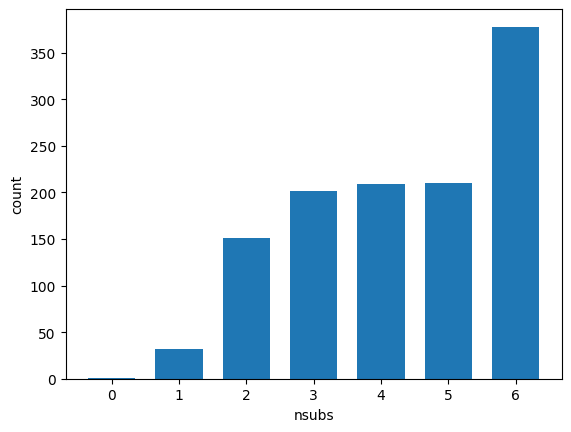

In [11]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
n5 = nsubs.count(5)
n6 = nsubs.count(6)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)
print(n5)
print(n6)

bin_edges = np.arange(-0.5,6.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)
plt.xlabel('nsubs')
plt.ylabel('count')

In [12]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,1183.0,0.615385,1.202789,0.0000,0.0000,0.0000,1.00000,4.0000
Pos2,1183.0,0.701606,1.251621,0.0000,0.0000,0.0000,1.00000,4.0000
Pos3,1183.0,0.606086,1.205752,0.0000,0.0000,0.0000,0.00000,4.0000
Pos4,1183.0,0.655114,1.214439,0.0000,0.0000,0.0000,1.00000,4.0000
Pos5,1183.0,0.726120,1.301198,0.0000,0.0000,0.0000,1.00000,4.0000
Pos6,1183.0,0.639053,1.232964,0.0000,0.0000,0.0000,1.00000,4.0000
Pos7,1183.0,0.631445,1.207461,0.0000,0.0000,0.0000,1.00000,4.0000
Pos8,1183.0,0.689772,1.241263,0.0000,0.0000,0.0000,1.00000,4.0000
Pos9,1183.0,0.674556,1.233248,0.0000,0.0000,0.0000,1.00000,4.0000
Pos10,1183.0,0.716822,1.290383,0.0000,0.0000,0.0000,1.00000,4.0000


/tmp/ipykernel_33451/2418938743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe[['target']])


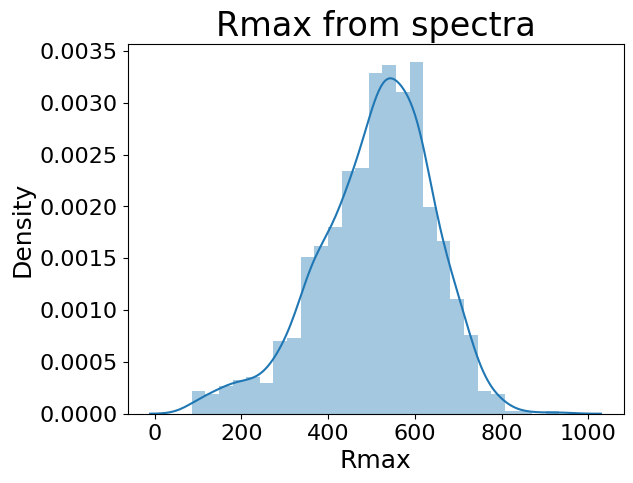

In [13]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

#sns.pairplot(dataframe[['target']], diag_kind='kde')
#sns.set_style('darkgrid')
sns.distplot(dataframe[['target']])
plt.title('Rmax from spectra',fontsize=24)
plt.xlabel('Rmax',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Text(0, 0.5, 'Rmax')

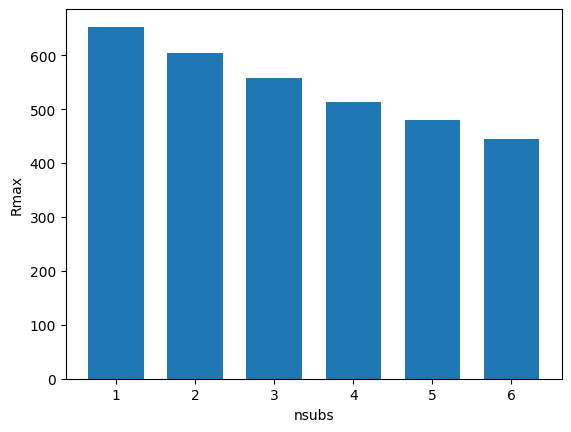

In [14]:
# Rmax as a function of nsubs
Rmax = []
Rmax[:] = dataframe['target']

nsubs1 = [i for i in range(len(nsubs)) if nsubs[i]==1]
nsubs2 = [i for i in range(len(nsubs)) if nsubs[i]==2]
nsubs3 = [i for i in range(len(nsubs)) if nsubs[i]==3]
nsubs4 = [i for i in range(len(nsubs)) if nsubs[i]==4]
nsubs5 = [i for i in range(len(nsubs)) if nsubs[i]==5]
nsubs6 = [i for i in range(len(nsubs)) if nsubs[i]==6]

Rmax1 = [Rmax[i] for i in nsubs1]
Rmax2 = [Rmax[i] for i in nsubs2]
Rmax3 = [Rmax[i] for i in nsubs3]
Rmax4 = [Rmax[i] for i in nsubs4]
Rmax5 = [Rmax[i] for i in nsubs5]
Rmax6 = [Rmax[i] for i in nsubs6]

Rmax1_mean = np.mean(Rmax1)
Rmax2_mean = np.mean(Rmax2)
Rmax3_mean = np.mean(Rmax3)
Rmax4_mean = np.mean(Rmax4)
Rmax5_mean = np.mean(Rmax5)
Rmax6_mean = np.mean(Rmax6)

Rmax_mean = [Rmax1_mean, Rmax2_mean, Rmax3_mean, Rmax4_mean, Rmax5_mean, Rmax6_mean]

bin_edges = np.arange(1.5,6.5+1,1)
plt.bar([1,2,3,4,5,6],Rmax_mean, width=0.7)
plt.xlabel('nsubs')
plt.ylabel('Rmax')

In [8]:
# remove data with R~8

#dataframe = dataframe[ dataframe['target']>10 ]
#dataframe.describe().transpose()

""" # remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose()) """

" # remove data with target<Rmin\nRmin = 380\ndataframe = dataframe[ dataframe['target']>Rmin ]\nprint(dataframe.describe().transpose()) "

In [15]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,1183.0,6.153846e-01,1.202789,0.000000,0.000000,0.000000,1.000000,4.000000
Pos2,1183.0,7.016061e-01,1.251621,0.000000,0.000000,0.000000,1.000000,4.000000
Pos3,1183.0,6.060862e-01,1.205752,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,1183.0,6.551141e-01,1.214439,0.000000,0.000000,0.000000,1.000000,4.000000
Pos5,1183.0,7.261200e-01,1.301198,0.000000,0.000000,0.000000,1.000000,4.000000
Pos6,1183.0,6.390533e-01,1.232964,0.000000,0.000000,0.000000,1.000000,4.000000
Pos7,1183.0,6.314455e-01,1.207461,0.000000,0.000000,0.000000,1.000000,4.000000
Pos8,1183.0,6.897718e-01,1.241263,0.000000,0.000000,0.000000,1.000000,4.000000
Pos9,1183.0,6.745562e-01,1.233248,0.000000,0.000000,0.000000,1.000000,4.000000
Pos10,1183.0,7.168216e-01,1.290383,0.000000,0.000000,0.000000,1.000000,4.000000


In [16]:
# One-hot encode inpute features manually 
n_data = dataset.shape[0]
n_atom_types = 5   # (H,Fl,Cl,Br,I)
#n_atom_types = 5   # (H,CN,CHO,COOH,NO2)
n_pos = 16         # 6-helicenes have 16 possible positions to be occupied
n_features = int(n_atom_types*n_pos)
x_data = np.zeros( (n_data, n_features) )
y_data = np.zeros(n_data)

n_labels = 1
data = np.zeros( (n_data, n_features+n_labels) )

dataset_np = dataset.to_numpy()
#print(dataset_np.shape)
for i in range(n_data):
    for j in range(n_pos):
        atom_id = int(dataset_np[i,j])
        x_data[i,j*n_atom_types+atom_id] = 1.0

    #print(x_data[i,:])
    #print(dataset_np[i,:16])

    y_data[i] = dataset_np[i,n_pos]

    data[i,0:n_features] = x_data[i,:] 
    data[i,n_features] = y_data[i]

print(x_data.shape)
print(y_data.shape)
print(data.shape)


(1183, 80)
(1183,)
(1183, 81)


In [17]:
# number of molecules with two adjacent subsituents

n_mol_adj = 0
for i in range(n_data):
    x_molecule = dataset_np[i,0:n_pos]
    for j in range(n_pos-1):
        if( x_molecule[j]>0 and x_molecule[j+1]>0 ):
            n_mol_adj = n_mol_adj + 1
            #print(x_molecule)
            break
print(n_mol_adj)
perc_adj = np.round(float(n_mol_adj/n_data)*100,2)
print(str(perc_adj)+ ' %'+' of the data has adjacent substituents')

770
65.09 % of the data has adjacent substituents


In [18]:
# dimension of tensorial product space
n_dim_2body = n_atom_types * n_atom_types
# number 2-body of components 
n_features_2body = (n_pos-1) * n_dim_2body


In [19]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#x_data = data[:,0:n_features]
#y_data = data[:,n_features]
#data = shuffle(data, random_state=39)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(x_data_both, y_data, test_size=0.2, random_state=42)

print(len(x_train), 'training examples')
print(len(x_test), 'test and validation examples')
print(x_train.shape)
print(y_train.shape)

946 training examples
237 test and validation examples
(946, 80)
(946,)


In [20]:
# Define layer for tensorial product and be able to load a pre-trained model

#def einsum_fn( x1,x2 ):
#    return tf.einsum('bij,bkj->bik', x1, x2)

class EinsumLayer(tf.keras.layers.Layer):
    """
    Layer wrapping a single tf.einsum operation.

    Usage:
    x = EinsumLayer("bmhwf,bmoh->bmowf")((x1, x2))
    """

    def __init__(self, equation: str):
        super().__init__()
        self.equation = equation

    def call(self, inputs, *args, **kwargs):
        return tf.einsum(self.equation, *inputs)

    def get_config(self):
        return {"equation": self.equation}

In [21]:
# 2-body model with two inputs

# -------------------------------------------------------------------
# INPUTS
# -------------------------------------------------------------------
print('INPUTS')

#inputs_1b = tf.keras.Input(shape=(n_features,),name='Molecule')
#inputs_1b = tf.keras.Input(shape=(None,n_features),name='Molecule')
inputs_1b = tf.keras.Input(shape=(n_features,),name='Molecule')
print(inputs_1b)

# -------------------------------------------------------------------
# 1-body term
# -------------------------------------------------------------------
print()
print('1-BODY')


# Split the input vector into differents positions with cropping
inputs_1b_aux = tf.keras.layers.Reshape((n_features,1), input_shape=(n_features,),name='Molecule_aux')(inputs_1b)

single_position = []
for i in range(n_pos):
    init = i * n_atom_types
    end = init + n_atom_types
    left_crop = init
    right_crop = n_features - end
    pos_i = tf.keras.layers.Cropping1D(cropping=(left_crop,right_crop),name='Pos_'+str(i))(inputs_1b_aux)
    #print(pos_i)
    single_position.append(pos_i)
print(len(single_position))

# Define architecture of 1-body models
def model_1body():
    inputs = tf.keras.Input( shape=(n_atom_types,) )
    outputs = tf.keras.layers.Dense(1,use_bias=False,kernel_initializer='random_normal',name='1B_'+str(i))(inputs)
    return tf.keras.Model(inputs,outputs, name='1B_'+str(i))

# save 8 models into a list 
models_1b = []
for i in range(int(n_pos/2)):
    model_i = model_1body()
    models_1b.append(model_i)

# Apply each model to each position
outputs_1b = []
# Positions 1-8
for i in range(int(n_pos/2)):
    output_i = models_1b[i]( single_position[i] )
    outputs_1b.append( output_i )
# Positions 9-16
for i in range(int(n_pos/2),n_pos):
    output_i = models_1b[n_pos-1-i]( single_position[i] )
    outputs_1b.append( output_i )    
print(len(outputs_1b))

# -------------------------------------------------------------------
# 2-body term
# -------------------------------------------------------------------
print()
print('2-BODY')

# Define 2-body inputs
single_pair = []
# Positions 1-8 (left side of the molecule)
for j in range(8):
    xj = single_position[j]          # shape (None,5,1)
    xj_next = single_position[j+1]   # shape (None,5,1)
    #pair_j = tf.tensordot(xj,xj_next,axes=0)
    #pair_j = tf.tensordot(xj,xj_next,axes=[[2],[2]])
    #pair_j = tf.einsum('bij,bkj->bik', xj, xj_next)   # shape (None,5,5)
    #pair_j = tf.keras.layers.Lambda(einsum_fn)((xj, xj_next))   # shape (None,5,5)
    pair_j = EinsumLayer('bij,bkj->bik')((xj, xj_next))   # shape (None,5,5)
    pair_j = tf.keras.layers.Flatten()(pair_j)   # shape (None,25)
    single_pair.append(pair_j)
""" # Positions 16-10 (right side of the molecule).
# Position 9 is not included because it was taken into account before, 
# in the term j_8 and j_next=9 from the previous left side calculation.
# To respect the simmetry, j_next is to the left.
#for j in reversed(range(9,16)): """
# Positions 16-9 (right side of the molecule)
for j in reversed(range(8,16)):
    xj = single_position[j]
    xj_next = single_position[j-1]
    #pair_j = tf.tensordot(xj,xj_next,axes=0)
    #pair_j = tf.tensordot(xj,xj_next,axes=[[2],[2]])
    #pair_j = tf.einsum('bij,bkj->bik', xj, xj_next)
    #pair_j = tf.keras.layers.Lambda(einsum_fn)((xj, xj_next))   # shape (None,5,5)
    pair_j = EinsumLayer('bij,bkj->bik')((xj, xj_next))   # shape (None,5,5)
    pair_j = tf.keras.layers.Flatten()(pair_j)
    single_pair.append(pair_j)  
print(len(single_pair))  

# Define architecture of 2-body models
def model_2body():
    inputs = tf.keras.Input( shape=(n_dim_2body,) )
    #inputs = tf.keras.Input( shape=(None, 5, None, 5) )
    outputs = tf.keras.layers.Dense(1,use_bias=False,kernel_initializer='random_normal',name='2B_'+str(i))(inputs)
    return tf.keras.Model(inputs,outputs, name='2B_'+str(i))

# save 8 models into a list 
models_2b = []
for i in range(int(n_pos/2)):
    model_i = model_2body()
    models_2b.append(model_i)

# Apply each model to each pair
outputs_2b = []
# Pairs 1-8 (left side of the molecule)
for i in range(8):    
    output_i = models_2b[i]( single_pair[i] )
    outputs_2b.append( output_i )
""" # Pairs 9-15 (rigth side of the molecule)
#for i in range(8,16-1): """
# Pairs 9-16 (rigth side of the molecule)
for i in range(8,16):
    output_i = models_2b[i-8]( single_pair[i] )
    outputs_2b.append( output_i )
print(len(outputs_2b))

# -------------------------------------------------------------------
# Global model
# -------------------------------------------------------------------
print()
print('Global')

sum1 = tf.keras.layers.Add(name='SUM_1B')(outputs_1b)
sum2 = tf.keras.layers.Add(name='SUM_2B')(outputs_2b)
global_output = tf.keras.layers.Add(name='SUM')([sum1,sum2])

model = tf.keras.Model(inputs=inputs_1b,outputs=global_output)
model.summary()

tf.keras.utils.plot_model(model, "./Models/2body_invariant_model.png", show_shapes=True)

learning_rate = 0.01
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error')

INPUTS
KerasTensor(type_spec=TensorSpec(shape=(None, 80), dtype=tf.float32, name='Molecule'), name='Molecule', description="created by layer 'Molecule'")

1-BODY
16


2023-09-11 13:14:58.139183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-11 13:14:58.196017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-09-11 13:14:58.196257: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-09-11 13:14:58.197796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

16

2-BODY
16
16

Global
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Molecule (InputLayer)          [(None, 80)]         0           []                               
                                                                                                  
 Molecule_aux (Reshape)         (None, 80, 1)        0           ['Molecule[0][0]']               
                                                                                                  
 Pos_0 (Cropping1D)             (None, 5, 1)         0           ['Molecule_aux[0][0]']           
                                                                                                  
 Pos_1 (Cropping1D)             (None, 5, 1)         0           ['Molecule_aux[0][0]']           
                                                                     

In [22]:
# Train the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=50, min_lr=1e-8)
                                            #patience=50, min_lr=1e-8)

epochs = 500
batch_size = 4


history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)

Epoch 1/500
213/213 - 1s - loss: 0.5172 - val_loss: 0.3551 - lr: 0.0100 - 1s/epoch - 6ms/step
Epoch 2/500
213/213 - 0s - loss: 0.3915 - val_loss: 0.3718 - lr: 0.0100 - 204ms/epoch - 959us/step
Epoch 3/500
213/213 - 0s - loss: 0.3659 - val_loss: 0.3709 - lr: 0.0100 - 212ms/epoch - 993us/step
Epoch 4/500
213/213 - 0s - loss: 0.3675 - val_loss: 0.3810 - lr: 0.0100 - 216ms/epoch - 1ms/step
Epoch 5/500
213/213 - 0s - loss: 0.3685 - val_loss: 0.3989 - lr: 0.0100 - 214ms/epoch - 1ms/step
Epoch 6/500
213/213 - 0s - loss: 0.3719 - val_loss: 0.3955 - lr: 0.0100 - 220ms/epoch - 1ms/step
Epoch 7/500
213/213 - 0s - loss: 0.3741 - val_loss: 0.3532 - lr: 0.0100 - 220ms/epoch - 1ms/step
Epoch 8/500
213/213 - 0s - loss: 0.3621 - val_loss: 0.3616 - lr: 0.0100 - 343ms/epoch - 2ms/step
Epoch 9/500
213/213 - 0s - loss: 0.3788 - val_loss: 0.3869 - lr: 0.0100 - 256ms/epoch - 1ms/step
Epoch 10/500
213/213 - 0s - loss: 0.3477 - val_loss: 0.3490 - lr: 0.0100 - 207ms/epoch - 972us/step
Epoch 11/500
213/213 - 0s 

Best epoch: 184


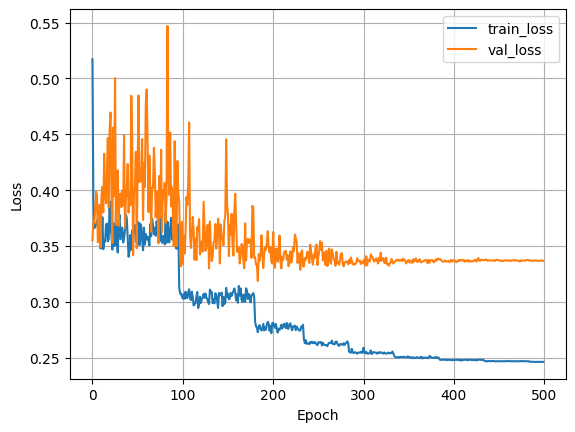

In [23]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [24]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

8/8 [==============================] - 0s 968us/step
(237, 1)
(237, 1)


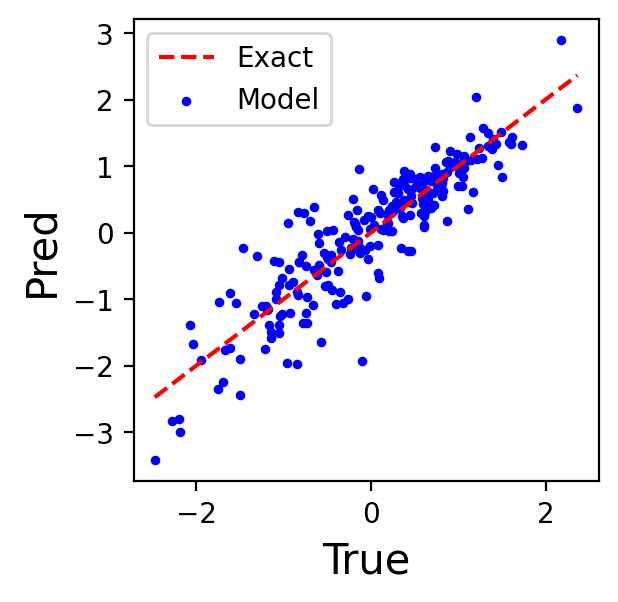

Test MAE: 0.3180672615305156
Test MSE: 0.18559255484559561


In [25]:
# Pred vs True values on test set 

y_pred = model.predict(x_test)
#y_pred = model.predict(x=[x_test[:,0:n_features],x_test[:,n_features:]])
y_pred.shape
y_true = np.zeros((len(y_test),1))
y_true[:,0] = y_test[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
test_mse = mean_squared_error(y_true,y_pred)

print("Test MAE: "+str(test_mae))
print("Test MSE: "+str(test_mse))

In [26]:
# save model

#reloaded_model = tf.keras.models.load_model('R_model')
model.save('./Models/R_model_invariant_2body')

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_2body_Halogenos/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_2body_Halogenos/assets


30/30 [==============================] - 0s 773us/step


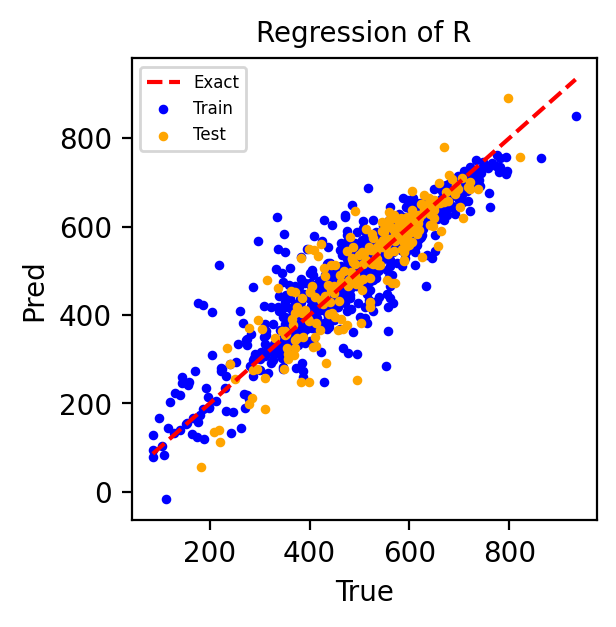

Train MAE (non-normalized): 33.727589332448304
Train RMSE (non-normalized): 53.22089775575756
Train MAPE (non-normalized): 8.46766611842644
Train R2 (non-normalized): 0.8445875655935464

Test MAE (non-normalized): 42.07703926440533
Test RMSE (non-normalized): 56.99102653502293
Test MAPE (non-normalized): 9.659101842386981
Test R2 (non-normalized): 0.7763871539691248


In [27]:
# Evaluate the model with non-normalized units on the whole dataset

y_pred_test = model.predict(x_test)
#y_pred_test = model.predict(x=[x_test[:,0:n_features],x_test[:,n_features:]])
y_true_test = np.zeros((len(y_test),1))
y_true_test[:,0] = y_test[:]

y_pred_train = model.predict(x_train)
#y_pred_train = model.predict(x=[x_train[:,0:n_features],x_train[:,n_features:]])
y_true_train = np.zeros((len(y_train),1))
y_true_train[:,0] = y_train[:]

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("Train MAE (non-normalized): "+str(train_mae))
train_mse = mean_squared_error(y_true_train,y_pred_train,squared=False)
print("Train RMSE (non-normalized): "+str(train_mse))
train_mape = mean_absolute_percentage_error(y_true_train,y_pred_train)*100
print("Train MAPE (non-normalized): "+str(train_mape))
train_r2 = r2_score(y_true_train,y_pred_train)
print("Train R2 (non-normalized): "+str(train_r2))

print()
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("Test MAE (non-normalized): "+str(test_mae))
test_mse = mean_squared_error(y_true_test,y_pred_test,squared=False)
print("Test RMSE (non-normalized): "+str(test_mse))
test_mape = mean_absolute_percentage_error(y_true_test,y_pred_test)*100
print("Test MAPE (non-normalized): "+str(test_mape))
test_r2 = r2_score(y_true_test,y_pred_test)
print("Test R2 (non-normalized): "+str(test_r2))

#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

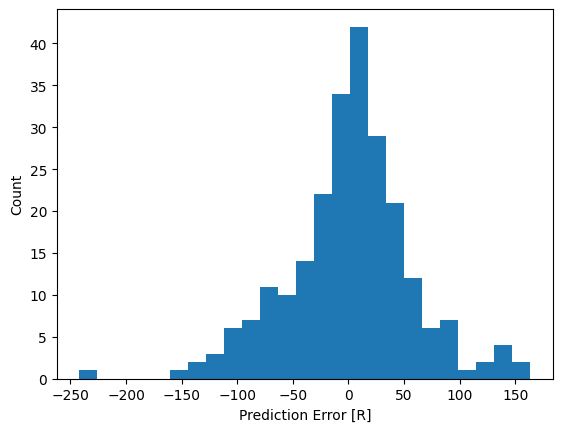

In [28]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


[ 0.  4. 36. 37. 49. 33. 78.]
[        nan 16.3100342  29.47379561 31.78224847 46.40291471 34.74964861
 54.48124499]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


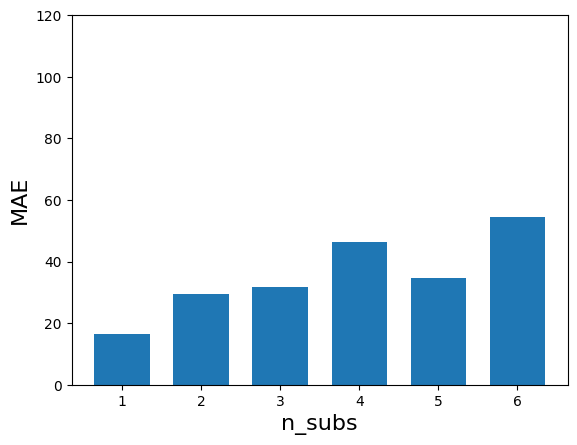

In [29]:
# Error for different nsubs on Test set

#x_test = test_features.to_numpy()

nsubs_test = np.zeros( x_test.shape[0] )
#print(x_test[0,:])

# compute number of substitutes for each data test
for i in range(len(nsubs_test)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_test[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_test[i] = nsubs_i
#print(nsubs_test)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
error5 = []
error6 = []
num_subs = np.zeros(7)
for i in range(len(nsubs_test)):
    error_i = y_pred_test[i] - y_true_test[i]
    if(nsubs_test[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_test[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_test[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_test[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_test[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1
    if(nsubs_test[i]==5): 
        error5.append(error_i)
        num_subs[5] +=1
    if(nsubs_test[i]==6): 
        error6.append(error_i)
        num_subs[6] +=1

error_nsubs = np.zeros(7)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))
error_nsubs[5] = np.mean(np.abs(error5))
error_nsubs[6] = np.mean(np.abs(error6))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,6.5+1,1)
plt.bar([0,1,2,3,4,5,6],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.ylim([0,120])
plt.show()

[  1.  28. 114. 166. 160. 177. 300.]
[24.63774629 20.7081527  17.6720278  28.88060858 36.17205331 42.09296768
 37.51685829]


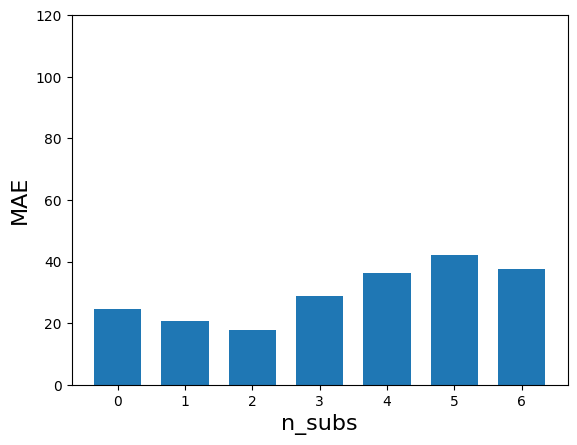

In [30]:
# Error for different nsubs on Training set

nsubs_train = np.zeros( x_train.shape[0] )
#print(x_train[0,:])

# compute number of substitutes for each data train
for i in range(len(nsubs_train)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_train[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_train[i] = nsubs_i
#print(nsubs_train)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
error5 = []
error6 = []
num_subs = np.zeros(7)
for i in range(len(nsubs_train)):
    error_i = y_pred_train[i] - y_true_train[i]
    if(nsubs_train[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_train[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_train[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_train[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_train[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1
    if(nsubs_train[i]==5): 
        error5.append(error_i)
        num_subs[5] +=1
    if(nsubs_train[i]==6): 
        error6.append(error_i)
        num_subs[6] +=1

error_nsubs = np.zeros(7)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))
error_nsubs[5] = np.mean(np.abs(error5))
error_nsubs[6] = np.mean(np.abs(error6))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,6.5+1,1)
plt.bar([0,1,2,3,4,5,6],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.ylim([0,120])
plt.show()

In [31]:
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)
    
print()
print('1-BODY')
for i in range(8):
    print(weights[i].flatten()*R_std)

print()
print('2-BODY')
for i in range(8,16):
    print(weights[i].flatten()*R_std)    

1B_0/kernel:0 (5, 1)
1B_1/kernel:0 (5, 1)
1B_2/kernel:0 (5, 1)
1B_3/kernel:0 (5, 1)
1B_4/kernel:0 (5, 1)
1B_5/kernel:0 (5, 1)
1B_6/kernel:0 (5, 1)
1B_7/kernel:0 (5, 1)
2B_0/kernel:0 (25, 1)
2B_1/kernel:0 (25, 1)
2B_2/kernel:0 (25, 1)
2B_3/kernel:0 (25, 1)
2B_4/kernel:0 (25, 1)
2B_5/kernel:0 (25, 1)
2B_6/kernel:0 (25, 1)
2B_7/kernel:0 (25, 1)

1-BODY
[ 21.9769   -47.134506 -40.03069  -40.944897 -33.75354 ]
[ -6.9593616 -21.965218    2.4537108 -10.463532   -4.9831257]
[ -7.4396424 -14.37745    -6.1350584   5.7685094  -4.699948 ]
[ 21.77133   11.144044 -30.74239  -40.07143  -66.01872 ]
[ 22.535471   -3.2500944 -24.979473  -48.648674  -54.42726  ]
[  5.674966  -9.315391 -19.78322  -21.431026 -50.914806]
[  9.88165    -7.2486873 -20.143312  -17.59811   -52.944298 ]
[  2.151583  -6.511422 -20.009638 -28.143902 -34.38131 ]

2-BODY
[   1.1486479   -8.4667225   10.607428    33.209793    57.122272
  -40.035156   -38.475193    11.428206   -21.834858   -20.131813
  -38.857204    17.270548   -13.48

In [32]:
# How to interpret 2-body coefficients

x1 = np.zeros(5)
x2 = np.zeros(5)

# (H, F, Cl, Br, I) = (0, 1, 2, 3, 4)
x1[3] = 1.0   # Br
x2[4] = 1.0   # I

x12 = np.tensordot(x1,x2,axes=0)
print(x12)
x12 = x12.flatten()
print()
print(x12)
x12 = x12.reshape(5,5)
print()
print(x12)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0.]

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


In [33]:
# 2-Body coefficients

a_2b = weights[8:16]
a_2b = np.array(a_2b)
print(a_2b.shape)
a_2b = a_2b[:,:,0]
print(a_2b.shape)

a_matrix = a_2b.reshape((8,5,5))
print(a_matrix.shape)

#np.set_printoptions(precision=2)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
for i in range(a_matrix.shape[0]):
    print()
    print(np.round(a_matrix[i,:,:]*R_std,2))

(8, 25, 1)
(8, 25)
(8, 5, 5)

[[1.150 -8.470 10.610 33.210 57.120]
 [-40.040 -38.480 11.430 -21.830 -20.130]
 [-38.860 17.270 -13.480 -21.180 -11.540]
 [-22.400 -27.080 -45.960 32.810 35.180]
 [38.830 9.300 36.050 -71.560 -146.610]]

[[-18.070 -21.110 -10.760 -1.800 7.800]
 [-13.530 -8.290 54.570 -90.890 0.910]
 [0.880 -3.490 -1.970 -18.370 -2.530]
 [14.570 1.030 -50.420 26.650 -29.110]
 [-11.830 -5.190 -10.630 5.940 -21.500]]

[[-3.230 -12.000 -9.640 -21.750 -26.510]
 [13.480 -13.380 -7.060 -21.470 -46.270]
 [19.350 1.270 12.050 7.080 -82.660]
 [14.670 49.160 21.950 -66.990 -45.380]
 [17.370 29.960 -21.400 10.610 -70.060]]

[[7.980 20.460 29.910 35.810 6.600]
 [-1.260 27.990 -16.610 -9.680 -54.250]
 [13.380 -2.540 -50.640 -30.190 -29.050]
 [30.800 -42.950 -6.170 -51.590 -92.910]
 [28.220 -45.500 -133.200 -191.080 -64.250]]

[[22.190 -0.200 6.260 -2.270 -11.340]
 [19.300 13.050 4.430 -28.100 -69.290]
 [-18.240 11.770 -38.780 -6.280 8.870]
 [-16.590 -33.170 -5.010 -35.360 -28.640]
 [-15

In [34]:
# Invariance test

x1 = dataset_np[132,0:16].copy()
x1_flip = x1.copy()
x1_flip = np.flip(x1)

# one-hot encode

x1_ohe = np.zeros((1,n_features))
x1_flip_ohe = np.zeros((1,n_features))
for j in range(n_pos):
    #atom_id = int(dataset_np[0,j])
    atom_id = int(x1[j])
    x1_ohe[0,j*n_atom_types+atom_id] = 1.0
    atom_id = int(x1_flip[j])
    x1_flip_ohe[0,j*n_atom_types+atom_id] = 1.0

print(x1)
y_pred1 = model.predict(x1_ohe)
print(y_pred1[0])

print()
print(x1_flip)
y_pred1_flip = model.predict(x1_flip_ohe)
print(y_pred1_flip[0])

[0.000 3.000 0.000 0.000 0.000 0.000 3.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000]
1/1 [==============================] - 0s 16ms/step
[1.379]

[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 3.000 0.000 0.000
 0.000 0.000 3.000 0.000]
1/1 [==============================] - 0s 18ms/step
[1.379]


In [35]:
# Save weights
print('1-BODY')
weights_1b = np.zeros((8,n_atom_types))
for i in range(8):
    weights_1b[i] = weights[i].flatten()    
    print('Pos'+str(i)+': '+str(weights_1b[i]*R_std))

print()
print('2-BODY')
weights_2b = np.zeros((8,n_dim_2body))
for i in range(8,16):
    #print(i)
    weights2b = weights[i].flatten()    
    weights_2b[i-8] = weights[i].flatten()    
    print('Pos'+str(i-8)+': '+str(weights_2b[i-8]*R_std))    

1-BODY
Pos0: [21.977 -47.135 -40.031 -40.945 -33.754]
Pos1: [-6.959 -21.965 2.454 -10.464 -4.983]
Pos2: [-7.440 -14.377 -6.135 5.769 -4.700]
Pos3: [21.771 11.144 -30.742 -40.071 -66.019]
Pos4: [22.535 -3.250 -24.979 -48.649 -54.427]
Pos5: [5.675 -9.315 -19.783 -21.431 -50.915]
Pos6: [9.882 -7.249 -20.143 -17.598 -52.944]
Pos7: [2.152 -6.511 -20.010 -28.144 -34.381]

2-BODY
Pos0: [1.149 -8.467 10.607 33.210 57.122 -40.035 -38.475 11.428 -21.835 -20.132
 -38.857 17.271 -13.481 -21.179 -11.541 -22.395 -27.080 -45.960 32.812
 35.180 38.834 9.302 36.047 -71.563 -146.606]
Pos1: [-18.071 -21.105 -10.760 -1.805 7.799 -13.526 -8.285 54.572 -90.886 0.905
 0.882 -3.486 -1.974 -18.366 -2.530 14.568 1.034 -50.415 26.647 -29.112
 -11.831 -5.188 -10.630 5.937 -21.498]
Pos2: [-3.230 -12.003 -9.638 -21.748 -26.509 13.478 -13.381 -7.063 -21.471
 -46.271 19.353 1.272 12.047 7.078 -82.656 14.670 49.157 21.953 -66.986
 -45.382 17.373 29.958 -21.402 10.608 -70.060]
Pos3: [7.985 20.458 29.911 35.815 6.597 -1

In [36]:
# function to evaluate 1-body and 2-body terms with the optimal parameters

def calculate_R( x_input ):

    R_model = float(model.predict(x=x_input))
    R_model = R_model * R_std + R_mean
    print(R_model)

    R_formula = 0

    #-------------------------
    # 1-BODY
    #-------------------------
    R1 = 0
    # Positions 1-8
    for i in range(int(n_pos/2)):
        init = i * n_atom_types
        end = init + n_atom_types
        x_i = x_input[0,init:end]
        R1 = R1 + np.dot(weights_1b[i],x_i)
    # Positions 9-16
    for i in range(int(n_pos/2),n_pos):
        init = i * n_atom_types
        end = init + n_atom_types
        x_i = x_input[0,init:end]
        R1 = R1 + np.dot(weights_1b[n_pos-1-i],x_i)

    #-------------------------
    # 2-BODY
    #-------------------------

    R2 = 0

    # First, define 2-body input pairs and save them

    single_pair = []
    # Positions 1-8 (left side of the molecule)
    for i in range(8):

        init = i * n_atom_types
        end = init + n_atom_types
        xi = x_input[0,init:end]

        init = (i+1) * n_atom_types
        end = init + n_atom_types
        xi_next = x_input[0,init:end]

        x_pair = np.tensordot(xi,xi_next,axes=0)
        x_pair = x_pair.flatten()        
        single_pair.append(x_pair)

    # Positions 16-10 (right side of the molecule).
    # Position 9 is not included because it was taken into account before, 
    # in the term j_8 and j_next=9 from the previous left side calculation.
    # To respect the simmetry, j_next is to the left.
    #for i in reversed(range(9,16)):
    for i in reversed(range(8,16)):

        init = i * n_atom_types
        end = init + n_atom_types
        xi = x_input[0,init:end]

        init = (i-1) * n_atom_types
        end = init + n_atom_types
        xi_next = x_input[0,init:end]

        x_pair = np.tensordot(xi,xi_next,axes=0)
        x_pair = x_pair.flatten()        
        single_pair.append(x_pair)

    # Once pairs have been defined, apply weights
    
    #print(single_pair)

    # Positions 1-8
    for i in range(int(n_pos/2)):
        x_pair = single_pair[i]
        R2 = R2 + np.dot(weights_2b[i],x_pair)

    # Positions 9-15
    #for i in range(8,16-1):
    for i in range(8,16):
        x_pair = single_pair[i]
        R2 = R2 + np.dot(weights_2b[i-8],x_pair)

    #-------------------------
    # TOTAL
    #-------------------------    
    
    R_formula = R1+R2
    R_formula = R_formula * R_std + R_mean
    print(R_formula)

    return R_model, R_formula

x_example = np.zeros((1,n_features))
x_example[0,:] = x_data[100,:]
print(x_example.shape)
R_model, R_formula = calculate_R(x_example)

# Flip example
x_flip_example = np.zeros((1,n_features))
for i in range(n_pos):
    init = i * n_atom_types
    end = init + n_atom_types
    x_i = x_example[0,init:end]
    i_flip = n_pos - i -1
    init = i_flip * n_atom_types
    end = init + n_atom_types
    x_flip_example[0,init:end] = x_i[:]

print()
#print(x_example)
#print(x_flip_example)
R_model, R_formula = calculate_R(x_flip_example)

# Flip example
x_ex = dataset_np[132,0:16].copy()
x_flip_ex = x_ex.copy()
x_flip_ex = np.flip(x_flip_ex)
print()
print(x_ex)
print(x_flip_ex)

x_ex_ohe = np.zeros((1,n_features))
x_flip_ex_ohe = np.zeros((1,n_features))
for j in range(n_pos):
    atom_id = int(x_ex[j])
    x_ex_ohe[0,j*n_atom_types+atom_id] = 1.0
    atom_id = int(x_flip_ex[j])
    x_flip_ex_ohe[0,j*n_atom_types+atom_id] = 1.0

R_model, R_formula = calculate_R(x_ex_ohe)
R_model, R_formula = calculate_R(x_flip_ex_ohe)

(1, 80)
1/1 [==============================] - 0s 17ms/step
540.8231174298826
540.8231158282249

1/1 [==============================] - 0s 15ms/step
540.8231292575085
540.8231158282249

[0.000 3.000 0.000 0.000 0.000 0.000 3.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000]
[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 3.000 0.000 0.000
 0.000 0.000 3.000 0.000]
1/1 [==============================] - 0s 14ms/step
691.3285870656289
691.3285790573404
1/1 [==============================] - 0s 14ms/step
691.3285870656289
691.3285790573404
